# Vehicle Detection

## Overview

This notebook contains an implementation to identify vehicles in a video from a front-facing camera on a car. The test images and project video are located in this [repository](https://github.com/abmantha/CarND-Vehicle-Detection).

The goals / steps of this project are the following: 
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Imports

In [94]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import glob
import time

import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Load Test Images

In [64]:
%matplotlib inline
# test_images_paths = ["test_images/test*.jpg", "test_images/kitti*.png", "test_images/kitti-main*.png"]
test_images_paths = ["test_images/test*.jpg"]
test_images = glob.glob(test_images_paths[0])
# test_kitti_extracted_images = glob.glob(test_images_paths[1])
# test_kitti_main_images = glob.glob(test_images_paths[2])

cars_images_paths = ["../CarND-Data-Vehicle-Detection/vehicles/GTI_Far/image*.png", 
                     "../CarND-Data-Vehicle-Detection/vehicles/GTI_Left/image*.png", 
                     "../CarND-Data-Vehicle-Detection/vehicles/GTI_MiddleClose/image*.png", 
                     "../CarND-Data-Vehicle-Detection/vehicles/GTI_Right/image*.png", 
                     "../CarND-Data-Vehicle-Detection/vehicles/KITTI_extracted/*.png"]

non_cars_images_paths = ["../CarND-Data-Vehicle-Detection/non-vehicles/Extras/extra*.png",
                         "../CarND-Data-Vehicle-Detection/non-vehicles/GTI/image*.png"]

cars = glob.glob(cars_images_paths[0])
cars.extend(glob.glob(cars_images_paths[1]))
cars.extend(glob.glob(cars_images_paths[2]))
cars.extend(glob.glob(cars_images_paths[3]))
cars.extend(glob.glob(cars_images_paths[4]))

non_cars = glob.glob(non_cars_images_paths[0])
non_cars.extend(glob.glob(non_cars_images_paths[1]))

print ("Length of cars dataset: ", len(cars))
print ("Length of non-cars dataset: ", len(non_cars))

Length of cars dataset:  8792
Length of non-cars dataset:  8968


## Plot Utility Functions

In [65]:
def plot_color_histogram(hist_channels, bin_centers, features): 
    if len(hist_channels) != 0: 
        fig = plt.figure(figsize=(12,3))

        plt.subplot(131)
        plt.bar(bin_centers, hist_channels[0][0])
        plt.xlim(0, 256)
        plt.title('Channel 1 Histogram')
        
        plt.subplot(132)
        plt.bar(bin_centers, hist_channels[1][0])
        plt.xlim(0, 256)
        plt.title('Channel 2 Histogram')
        
        plt.subplot(133)
        plt.bar(bin_centers, hist_channels[2][0])
        plt.xlim(0, 256)
        plt.title('Channel 3 Histogram')
        
        plt.show()
    else: 
        print ("Error with your function")
        
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]): 
    # Create figure and 3D axes
    fig = plt.figure(figsize=(6, 6))
    ax = Axes3D(fig)
    
    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])
    
    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)
    
    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), 
        edgecolors='none'
    )
    
    return ax

## Plotting

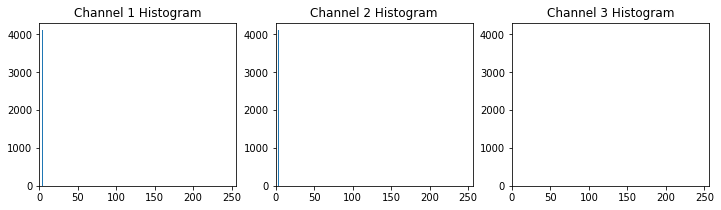

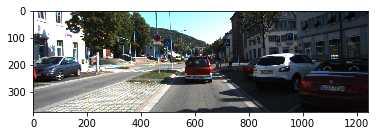

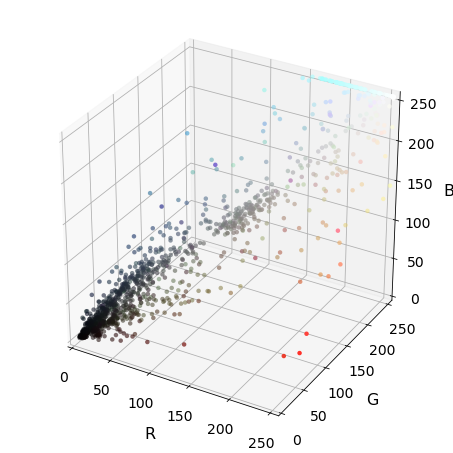

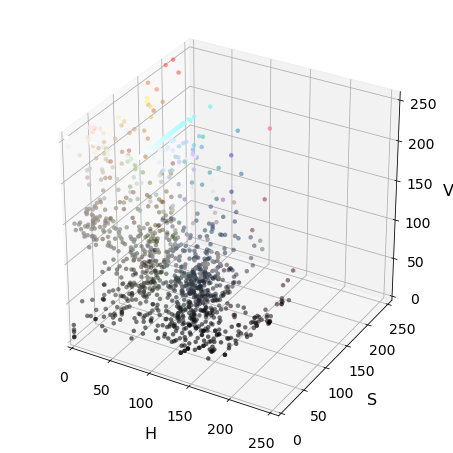

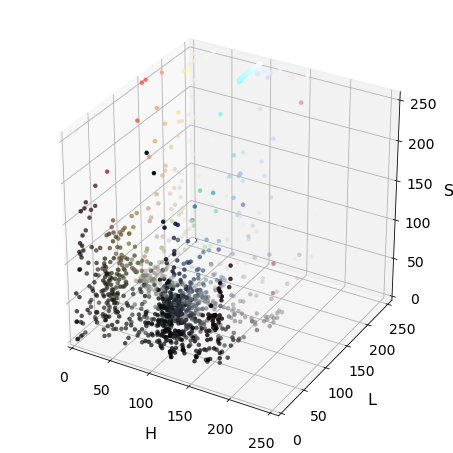

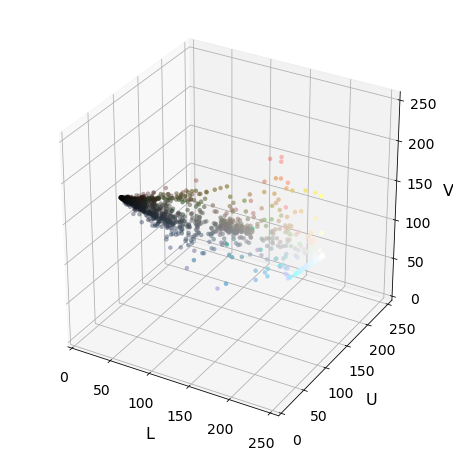

In [173]:
image = mpimg.imread(fname)
hist_channels, bin_centers, feature_vec = color_histogram(image, 32, (0, 256))    
plot_color_histogram(hist_channels, bin_centers, feature_vec)

img_name = kitti_extracted_images[0]
img = cv2.imread(img_name)
copy = np.copy(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

scale = max(copy.shape[0], copy.shape[1], 64) / 64
img_small = cv2.resize(copy, (np.int(copy.shape[1] / scale), np.int(copy.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2Luv)
img_small_rgb = img_small_RGB / 255.

plot3d(img_small_RGB, img_small_rgb)
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
plt.show()

## Pipeline Utilities

In [92]:
def generate_dataset_dict(car_list, not_car_list): 
    example_image = cv2.imread(car_list[0])
    data_dict = {}    
    data_dict["n_cars"] = len(car_list)
    data_dict["n_not_cars"] = len(not_car_list)
    data_dict["image_shape"] = example_image.shape
    data_dict["data_type"] = example_image.dtype
    return data_dict

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale,svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size=(32, 32), hist_bins=32):
        
    rectangles = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rectangles.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    
    return rectangles, draw_img


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def add_heat(heatmap, bbox_list): 
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    return heatmap

def apply_threshold(heatmap, threshold): 
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Parameter Tuning and Feature Extraction

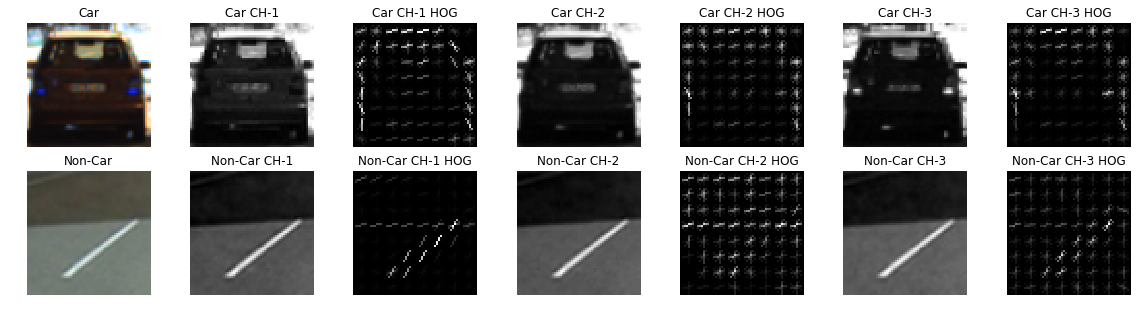

In [67]:
import random
rand_car_index = random.randint(0, len(cars))
rand_car_image = cv2.imread(cars[rand_car_index])

rand_non_index = random.randint(0, len(non_cars))
rand_non_image = cv2.imread(non_cars[rand_non_index])

def parameter_tuning_and_plot(car_image, non_car_image, orient, color_space, pix_per_cell, cell_per_block): 
    if (color_space != None):
        car_feature_image = cv2.cvtColor(car_image, color_space)
        non_car_feature_image = cv2.cvtColor(non_car_image, color_space)
    else:
        car_feature_image = np.copy(car_image)
        non_car_feature_image = np.copy(non_car_image)

    car_hog_features_1, car_hog_image_1 = get_hog_features(car_feature_image[:, :, 0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    car_hog_features_2, car_hog_image_2 = get_hog_features(car_feature_image[:, :, 1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    car_hog_features_3, car_hog_image_3 = get_hog_features(car_feature_image[:, :, 2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    non_car_hog_features_1, non_car_hog_image_1 = get_hog_features(non_car_feature_image[:, :, 0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    non_car_hog_features_2, non_car_hog_image_2 = get_hog_features(non_car_feature_image[:, :, 1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    non_car_hog_features_3, non_car_hog_image_3 = get_hog_features(non_car_feature_image[:, :, 2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        
    fig, axis = plt.subplots(2, 7, figsize=(20, 5))
    axis = axis.ravel()
    
    axis[0].imshow(car_image)
    axis[0].axis('off')
    axis[0].set_title("Car")
    
    axis[1].imshow(car_image[:, :, 0], cmap="gray")
    axis[1].axis('off')
    axis[1].set_title("Car CH-1")
    
    axis[2].imshow(car_hog_image_1, cmap="gray")
    axis[2].axis('off')
    axis[2].set_title("Car CH-1 HOG")
    
    axis[3].imshow(car_image[:, :, 1], cmap="gray")
    axis[3].axis('off')
    axis[3].set_title("Car CH-2")
        
    axis[4].imshow(car_hog_image_2, cmap="gray")
    axis[4].axis('off')
    axis[4].set_title("Car CH-2 HOG")
    
    axis[5].imshow(car_image[:, :, 2], cmap="gray")
    axis[5].axis('off')
    axis[5].set_title("Car CH-3")
    
    axis[6].imshow(car_hog_image_3, cmap="gray")
    axis[6].axis('off')
    axis[6].set_title("Car CH-3 HOG")

    axis[7].imshow(non_car_image)
    axis[7].axis('off')
    axis[7].set_title("Non-Car")
    
    axis[8].imshow(non_car_image[:, :, 0], cmap="gray")
    axis[8].axis('off')
    axis[8].set_title("Non-Car CH-1")
    
    axis[9].imshow(non_car_hog_image_1, cmap="gray")
    axis[9].axis('off')
    axis[9].set_title("Non-Car CH-1 HOG")
    
    axis[10].imshow(non_car_image[:, :, 1], cmap="gray")
    axis[10].axis('off')
    axis[10].set_title("Non-Car CH-2")
    
    axis[11].imshow(non_car_hog_image_2, cmap="gray")
    axis[11].axis('off')
    axis[11].set_title("Non-Car CH-2 HOG")
         
    axis[12].imshow(non_car_image[:, :, 2], cmap="gray")
    axis[12].axis('off')
    axis[12].set_title("Non-Car CH-3")
    
    axis[13].imshow(non_car_hog_image_3, cmap="gray")
    axis[13].axis('off')
    axis[13].set_title("Non-Car CH-3 HOG")
    
parameter_tuning_and_plot(rand_car_image, rand_non_image, 9, cv2.COLOR_RGB2YCrCb, 8, 2)

## SVM Training

__Experiment 1: Hist + HOG__
* Color Space: HLS
* Orient = 11
* Pix per Cell = 8
* Cell per Block = 2
* HOG Channel = 2
* Hist Bins = 32
* Y Min = image_shape[1]//2
* Y Max = image_shape[1] - 100
* __RESULTS__: Feature vector length: 2252 | 5.3 Seconds to train SVC... | Test Accuracy of SVC =  0.9738

__Experiment 2: Hist + Spatial + HOG__
* Color Space: YCrCb
* Orient = 9
* Pix per Cell = 8
* Cell per Block = 2
* HOG Channel = "ALL"
* Spatial Size = 32, 32
* Hist Bins = 32
* Y Min = image_shape[1]//2
* Y Max = image_shape[1] - 100
* __RESULTS__: Feature vector length: 8460 | 26.11 Seconds to train SVC... | Test Accuracy of SVC =  0.9896
* __RESULTS__: Feature vector length: 8460 | 23.99 Seconds to train SVC... | Test Accuracy of SVC =  0.9893
* __RESULTS__: Feature vector length: 8460 | 22.89 Seconds to train SVC... | Test Accuracy of SVC =  0.987

__Experiment 3: HOG (test purposes only)__
* __RESULTS__: Feature vector length: 5292 | 7.25 Seconds to train SVC... | Test Accuracy of SVC =  0.9783

In [68]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_cars = cars
sample_non_cars = non_cars

image = mpimg.imread(test_images[0])
image_shape = (image.shape[1], image.shape[0])
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [image_shape[1]//2, image_shape[1]-100] # Min and max in y to search in slide_window()

car_features = extract_features(sample_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(sample_non_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print ("Features are extracted")

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

print ("Applying normalization scaler")

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Features are extracted
Applying normalization scaler
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
22.89 Seconds to train SVC...
Test Accuracy of SVC =  0.987


# Complete Pipeline

In [87]:
def pipeline(image):
#     draw_image = np.copy(image)

#     # Uncomment the following line if you extracted training
#     # data from .png images (scaled 0 to 1 by mpimg) and the
#     # image you are searching is a .jpg (scaled 0 to 255)
#     image = image.astype(np.float32)/255

#     windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                         xy_window=(96, 96), xy_overlap=(0.5, 0.5))

#     hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
#                             spatial_size=spatial_size, hist_bins=hist_bins, 
#                             orient=orient, pix_per_cell=pix_per_cell, 
#                             cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                             hist_feat=hist_feat, hog_feat=hog_feat)                       

#     window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    return window_img

## Testing Pipeline 

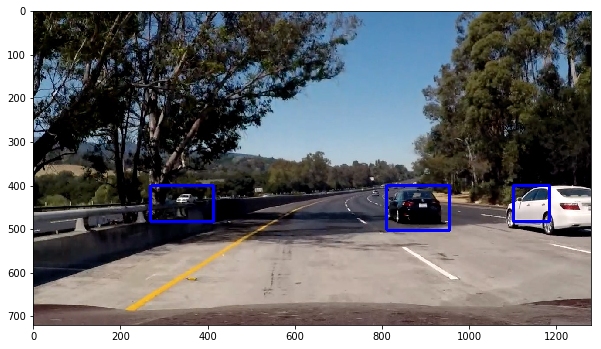

In [141]:
# for fname in test_images: 
#     ystart = 400
#     ystop = 700
#     scale = 2.5

#     image = cv2.imread(fname)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     pipelined_window = pipeline(image)
#     fig, axis = plt.subplots(1, 1, figsize=(10, 10))
#     axis.imshow(pipelined_window)

test_img = cv2.imread(test_images[4])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

rects = []

color_space = cv2.COLOR_RGB2YCrCb # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

ystart = 400
ystop = 600
scale = 1.3

rectangles, out_image = find_cars(test_img, ystart, ystop, scale, svc, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

# rectangles = [item for sublist in rects for item in sublist] 
# test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)

heat = np.zeros_like(test_img[:, :, 0]).astype(np.float)
heat = add_heat(heat, rectangles)
# heat = apply_threshold(heat, 1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

# Video Playback

### Test Video

In [470]:
test_video_outname = "test_video_with_detection.mp4"
test_video = VideoFileClip("test_video.mp4")
test_video_updated = test_video.fl_image(pipeline)
%time test_video_updated.write_videofile(test_video_outname, audio=False)

[MoviePy] >>>> Building video test_video_with_detection.mp4
[MoviePy] Writing video test_video_with_detection.mp4


 97%|█████████▋| 38/39 [00:07<00:00,  5.07it/s]      | 1/39 [00:00<00:08,  4.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_with_detection.mp4 

CPU times: user 7.39 s, sys: 274 ms, total: 7.66 s
Wall time: 8.39 s


In [471]:
HTML("""
<video width="480" height="275" controls>
    <source src="{0}">
</video>
""".format(test_video_outname))

# Project Video

In [233]:
project_video_outname = "project_video_with_detection.mp4"
project_video = VideoFileClip("project_video.mp4")
project_video_updated = project_video.fl_image(pipeline)
%time project_video_updated.write_videofile(project_video_outname, audio=False)

Drawing boxes
[MoviePy] >>>> Building video project_video_with_detection.mp4
[MoviePy] Writing video project_video_with_detection.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]  0%|          | 1/1261 [00:01<31:12,  1.49s/it]

Drawing boxes


  0%|          | 2/1261 [00:03<31:22,  1.50s/it]

Drawing boxes


  0%|          | 3/1261 [00:04<31:22,  1.50s/it]

Drawing boxes


  0%|          | 4/1261 [00:05<31:11,  1.49s/it]

Drawing boxes


  0%|          | 5/1261 [00:07<30:50,  1.47s/it]

Drawing boxes


  0%|          | 6/1261 [00:08<30:23,  1.45s/it]

Drawing boxes


  1%|          | 7/1261 [00:10<29:48,  1.43s/it]

Drawing boxes


  1%|          | 8/1261 [00:11<29:35,  1.42s/it]

Drawing boxes


  1%|          | 9/1261 [00:13<29:42,  1.42s/it]

Drawing boxes


  1%|          | 10/1261 [00:14<30:00,  1.44s/it]

Drawing boxes


  1%|          | 11/1261 [00:15<30:07,  1.45s/it]

Drawing boxes


  1%|          | 12/1261 [00:17<30:04,  1.44s/it]

Drawing boxes


  1%|          | 13/1261 [00:18<30:06,  1.45s/it]

Drawing boxes


  1%|          | 14/1261 [00:20<30:28,  1.47s/it]

Drawing boxes


  1%|          | 15/1261 [00:21<30:38,  1.48s/it]

Drawing boxes


  1%|▏         | 16/1261 [00:23<31:02,  1.50s/it]

Drawing boxes


  1%|▏         | 17/1261 [00:24<31:06,  1.50s/it]

Drawing boxes


  1%|▏         | 18/1261 [00:26<30:39,  1.48s/it]

Drawing boxes


  2%|▏         | 19/1261 [00:27<30:19,  1.46s/it]

Drawing boxes


  2%|▏         | 20/1261 [00:29<30:13,  1.46s/it]

Drawing boxes


  2%|▏         | 21/1261 [00:30<29:58,  1.45s/it]

Drawing boxes


  2%|▏         | 22/1261 [00:32<30:07,  1.46s/it]

Drawing boxes


  2%|▏         | 23/1261 [00:33<29:54,  1.45s/it]

Drawing boxes


  2%|▏         | 24/1261 [00:34<29:48,  1.45s/it]

Drawing boxes


  2%|▏         | 25/1261 [00:36<29:53,  1.45s/it]

Drawing boxes


  2%|▏         | 26/1261 [00:37<29:51,  1.45s/it]

Drawing boxes


  2%|▏         | 27/1261 [00:39<29:42,  1.44s/it]

Drawing boxes


  2%|▏         | 28/1261 [00:40<29:55,  1.46s/it]

Drawing boxes


  2%|▏         | 29/1261 [00:42<30:07,  1.47s/it]

Drawing boxes


  2%|▏         | 30/1261 [00:43<29:58,  1.46s/it]

Drawing boxes


  2%|▏         | 31/1261 [00:45<30:17,  1.48s/it]

Drawing boxes


  3%|▎         | 32/1261 [00:46<30:09,  1.47s/it]

Drawing boxes


  3%|▎         | 33/1261 [00:48<30:07,  1.47s/it]

Drawing boxes


  3%|▎         | 34/1261 [00:49<30:13,  1.48s/it]

Drawing boxes


  3%|▎         | 35/1261 [00:51<30:17,  1.48s/it]

Drawing boxes


  3%|▎         | 36/1261 [00:52<29:51,  1.46s/it]

Drawing boxes


  3%|▎         | 37/1261 [00:54<29:45,  1.46s/it]

Drawing boxes


  3%|▎         | 38/1261 [00:55<29:46,  1.46s/it]

Drawing boxes


  3%|▎         | 39/1261 [00:56<29:44,  1.46s/it]

Drawing boxes


  3%|▎         | 40/1261 [00:58<29:57,  1.47s/it]

Drawing boxes


  3%|▎         | 41/1261 [00:59<30:07,  1.48s/it]

Drawing boxes


  3%|▎         | 42/1261 [01:01<30:13,  1.49s/it]

Drawing boxes


  3%|▎         | 43/1261 [01:02<29:56,  1.48s/it]

Drawing boxes


  3%|▎         | 44/1261 [01:04<29:57,  1.48s/it]

Drawing boxes


  4%|▎         | 45/1261 [01:05<29:34,  1.46s/it]

Drawing boxes


  4%|▎         | 46/1261 [01:07<29:57,  1.48s/it]

Drawing boxes


  4%|▎         | 47/1261 [01:08<29:53,  1.48s/it]

Drawing boxes


  4%|▍         | 48/1261 [01:10<29:56,  1.48s/it]

Drawing boxes


  4%|▍         | 49/1261 [01:11<29:41,  1.47s/it]

Drawing boxes


  4%|▍         | 50/1261 [01:13<29:45,  1.47s/it]

Drawing boxes


  4%|▍         | 51/1261 [01:14<30:01,  1.49s/it]

Drawing boxes


  4%|▍         | 52/1261 [01:16<29:57,  1.49s/it]

Drawing boxes


  4%|▍         | 53/1261 [01:17<29:55,  1.49s/it]

Drawing boxes


  4%|▍         | 54/1261 [01:19<29:46,  1.48s/it]

Drawing boxes


  4%|▍         | 55/1261 [01:20<29:46,  1.48s/it]

Drawing boxes


  4%|▍         | 56/1261 [01:22<29:38,  1.48s/it]

Drawing boxes


  5%|▍         | 57/1261 [01:23<29:36,  1.48s/it]

Drawing boxes


  5%|▍         | 58/1261 [01:25<29:57,  1.49s/it]

Drawing boxes


  5%|▍         | 59/1261 [01:26<30:03,  1.50s/it]

Drawing boxes


  5%|▍         | 60/1261 [01:28<29:56,  1.50s/it]

Drawing boxes


  5%|▍         | 61/1261 [01:29<30:02,  1.50s/it]

Drawing boxes


  5%|▍         | 62/1261 [01:31<29:43,  1.49s/it]

Drawing boxes


  5%|▍         | 63/1261 [01:32<29:26,  1.47s/it]

Drawing boxes


  5%|▌         | 64/1261 [01:34<29:27,  1.48s/it]

Drawing boxes


  5%|▌         | 65/1261 [01:35<29:20,  1.47s/it]

Drawing boxes


  5%|▌         | 66/1261 [01:36<29:12,  1.47s/it]

Drawing boxes


  5%|▌         | 67/1261 [01:38<29:19,  1.47s/it]

Drawing boxes


  5%|▌         | 68/1261 [01:39<29:10,  1.47s/it]

Drawing boxes


  5%|▌         | 69/1261 [01:41<28:57,  1.46s/it]

Drawing boxes


  6%|▌         | 70/1261 [01:42<29:11,  1.47s/it]

Drawing boxes


  6%|▌         | 71/1261 [01:44<29:05,  1.47s/it]

Drawing boxes


  6%|▌         | 72/1261 [01:45<29:05,  1.47s/it]

Drawing boxes


  6%|▌         | 73/1261 [01:47<29:01,  1.47s/it]

Drawing boxes


  6%|▌         | 74/1261 [01:48<29:21,  1.48s/it]

Drawing boxes


  6%|▌         | 75/1261 [01:50<29:33,  1.50s/it]

Drawing boxes


  6%|▌         | 76/1261 [01:51<29:25,  1.49s/it]

Drawing boxes


  6%|▌         | 77/1261 [01:53<29:16,  1.48s/it]

Drawing boxes


  6%|▌         | 78/1261 [01:54<28:50,  1.46s/it]

Drawing boxes


  6%|▋         | 79/1261 [01:56<29:00,  1.47s/it]

Drawing boxes


  6%|▋         | 80/1261 [01:57<28:53,  1.47s/it]

Drawing boxes


  6%|▋         | 81/1261 [01:59<28:45,  1.46s/it]

Drawing boxes


  7%|▋         | 82/1261 [02:00<28:48,  1.47s/it]

Drawing boxes


  7%|▋         | 83/1261 [02:01<28:47,  1.47s/it]

Drawing boxes


  7%|▋         | 84/1261 [02:03<28:39,  1.46s/it]

Drawing boxes


  7%|▋         | 85/1261 [02:04<28:49,  1.47s/it]

Drawing boxes


  7%|▋         | 86/1261 [02:06<29:03,  1.48s/it]

Drawing boxes


  7%|▋         | 87/1261 [02:07<28:57,  1.48s/it]

Drawing boxes


  7%|▋         | 88/1261 [02:09<28:47,  1.47s/it]

Drawing boxes


  7%|▋         | 89/1261 [02:10<29:00,  1.48s/it]

Drawing boxes


  7%|▋         | 90/1261 [02:12<29:05,  1.49s/it]

Drawing boxes


  7%|▋         | 91/1261 [02:13<29:08,  1.49s/it]

Drawing boxes


  7%|▋         | 92/1261 [02:15<28:54,  1.48s/it]

Drawing boxes


  7%|▋         | 93/1261 [02:16<29:03,  1.49s/it]

Drawing boxes


  7%|▋         | 94/1261 [02:18<28:57,  1.49s/it]

Drawing boxes


  8%|▊         | 95/1261 [02:19<28:36,  1.47s/it]

Drawing boxes


  8%|▊         | 96/1261 [02:21<28:41,  1.48s/it]

Drawing boxes


  8%|▊         | 97/1261 [02:22<28:32,  1.47s/it]

Drawing boxes


  8%|▊         | 98/1261 [02:24<28:31,  1.47s/it]

Drawing boxes


  8%|▊         | 99/1261 [02:25<28:34,  1.48s/it]

Drawing boxes


  8%|▊         | 100/1261 [02:27<28:42,  1.48s/it]

Drawing boxes


  8%|▊         | 101/1261 [02:28<28:46,  1.49s/it]

Drawing boxes


  8%|▊         | 102/1261 [02:30<28:28,  1.47s/it]

Drawing boxes


  8%|▊         | 103/1261 [02:31<28:24,  1.47s/it]

Drawing boxes


  8%|▊         | 104/1261 [02:33<28:14,  1.46s/it]

Drawing boxes


  8%|▊         | 105/1261 [02:34<28:25,  1.48s/it]

Drawing boxes


  8%|▊         | 106/1261 [02:36<28:34,  1.48s/it]

Drawing boxes


  8%|▊         | 107/1261 [02:37<28:19,  1.47s/it]

Drawing boxes


  9%|▊         | 108/1261 [02:38<28:12,  1.47s/it]

Drawing boxes


  9%|▊         | 109/1261 [02:40<28:07,  1.47s/it]

Drawing boxes


  9%|▊         | 110/1261 [02:41<27:44,  1.45s/it]

Drawing boxes


  9%|▉         | 111/1261 [02:43<27:56,  1.46s/it]

Drawing boxes


  9%|▉         | 112/1261 [02:44<28:03,  1.46s/it]

Drawing boxes


  9%|▉         | 113/1261 [02:46<27:57,  1.46s/it]

Drawing boxes


  9%|▉         | 114/1261 [02:47<28:00,  1.47s/it]

Drawing boxes


  9%|▉         | 115/1261 [02:49<27:45,  1.45s/it]

Drawing boxes


  9%|▉         | 116/1261 [02:50<27:57,  1.46s/it]

Drawing boxes


  9%|▉         | 117/1261 [02:52<27:51,  1.46s/it]

Drawing boxes


  9%|▉         | 118/1261 [02:53<27:50,  1.46s/it]

Drawing boxes


  9%|▉         | 119/1261 [02:55<27:50,  1.46s/it]

Drawing boxes


 10%|▉         | 120/1261 [02:56<27:37,  1.45s/it]

Drawing boxes


 10%|▉         | 121/1261 [02:58<28:15,  1.49s/it]

Drawing boxes


 10%|▉         | 122/1261 [02:59<28:03,  1.48s/it]

Drawing boxes


 10%|▉         | 123/1261 [03:00<28:04,  1.48s/it]

Drawing boxes


 10%|▉         | 124/1261 [03:02<27:42,  1.46s/it]

Drawing boxes


 10%|▉         | 125/1261 [03:03<27:19,  1.44s/it]

Drawing boxes


 10%|▉         | 126/1261 [03:05<27:10,  1.44s/it]

Drawing boxes


 10%|█         | 127/1261 [03:06<26:58,  1.43s/it]

Drawing boxes


 10%|█         | 128/1261 [03:08<26:56,  1.43s/it]

Drawing boxes


 10%|█         | 129/1261 [03:09<27:10,  1.44s/it]

Drawing boxes


 10%|█         | 130/1261 [03:10<27:07,  1.44s/it]

Drawing boxes


 10%|█         | 131/1261 [03:12<27:07,  1.44s/it]

Drawing boxes


 10%|█         | 132/1261 [03:13<27:02,  1.44s/it]

Drawing boxes


 11%|█         | 133/1261 [03:15<27:02,  1.44s/it]

Drawing boxes


 11%|█         | 134/1261 [03:16<27:07,  1.44s/it]

Drawing boxes


 11%|█         | 135/1261 [03:18<27:22,  1.46s/it]

Drawing boxes


 11%|█         | 136/1261 [03:19<27:13,  1.45s/it]

Drawing boxes


 11%|█         | 137/1261 [03:21<26:55,  1.44s/it]

Drawing boxes


 11%|█         | 138/1261 [03:22<26:50,  1.43s/it]

Drawing boxes


 11%|█         | 139/1261 [03:23<27:12,  1.45s/it]

Drawing boxes


 11%|█         | 140/1261 [03:25<27:52,  1.49s/it]

Drawing boxes


 11%|█         | 141/1261 [03:26<27:39,  1.48s/it]

Drawing boxes


 11%|█▏        | 142/1261 [03:28<27:25,  1.47s/it]

Drawing boxes


 11%|█▏        | 143/1261 [03:29<27:31,  1.48s/it]

Drawing boxes


 11%|█▏        | 144/1261 [03:31<27:39,  1.49s/it]

Drawing boxes


 11%|█▏        | 145/1261 [03:32<27:28,  1.48s/it]

Drawing boxes


 12%|█▏        | 146/1261 [03:34<27:20,  1.47s/it]

Drawing boxes


 12%|█▏        | 147/1261 [03:35<27:24,  1.48s/it]

Drawing boxes


 12%|█▏        | 148/1261 [03:37<27:17,  1.47s/it]

Drawing boxes


 12%|█▏        | 149/1261 [03:38<27:17,  1.47s/it]

Drawing boxes


 12%|█▏        | 150/1261 [03:40<27:24,  1.48s/it]

Drawing boxes


 12%|█▏        | 151/1261 [03:41<27:32,  1.49s/it]

Drawing boxes


 12%|█▏        | 152/1261 [03:43<27:15,  1.47s/it]

Drawing boxes


 12%|█▏        | 153/1261 [03:44<26:59,  1.46s/it]

Drawing boxes


 12%|█▏        | 154/1261 [03:46<26:38,  1.44s/it]

Drawing boxes


 12%|█▏        | 155/1261 [03:47<26:26,  1.43s/it]

Drawing boxes


 12%|█▏        | 156/1261 [03:48<26:31,  1.44s/it]

Drawing boxes


 12%|█▏        | 157/1261 [03:50<26:31,  1.44s/it]

Drawing boxes


 13%|█▎        | 158/1261 [03:51<26:27,  1.44s/it]

Drawing boxes


 13%|█▎        | 159/1261 [03:53<26:15,  1.43s/it]

Drawing boxes


 13%|█▎        | 160/1261 [03:54<26:14,  1.43s/it]

Drawing boxes


 13%|█▎        | 161/1261 [03:56<26:17,  1.43s/it]

Drawing boxes


 13%|█▎        | 162/1261 [03:57<26:18,  1.44s/it]

Drawing boxes


 13%|█▎        | 163/1261 [03:58<26:19,  1.44s/it]

Drawing boxes


 13%|█▎        | 164/1261 [04:00<26:29,  1.45s/it]

Drawing boxes


 13%|█▎        | 165/1261 [04:01<26:00,  1.42s/it]

Drawing boxes


 13%|█▎        | 166/1261 [04:03<25:53,  1.42s/it]

Drawing boxes


 13%|█▎        | 167/1261 [04:04<25:56,  1.42s/it]

Drawing boxes


 13%|█▎        | 168/1261 [04:06<26:05,  1.43s/it]

Drawing boxes


 13%|█▎        | 169/1261 [04:07<26:09,  1.44s/it]

Drawing boxes


 13%|█▎        | 170/1261 [04:08<26:11,  1.44s/it]

Drawing boxes


 14%|█▎        | 171/1261 [04:10<25:59,  1.43s/it]

Drawing boxes


 14%|█▎        | 172/1261 [04:11<25:52,  1.43s/it]

Drawing boxes


 14%|█▎        | 173/1261 [04:13<25:44,  1.42s/it]

Drawing boxes


 14%|█▍        | 174/1261 [04:14<25:58,  1.43s/it]

Drawing boxes


 14%|█▍        | 175/1261 [04:16<26:03,  1.44s/it]

Drawing boxes


 14%|█▍        | 176/1261 [04:17<26:00,  1.44s/it]

Drawing boxes


 14%|█▍        | 177/1261 [04:18<25:46,  1.43s/it]

Drawing boxes


 14%|█▍        | 178/1261 [04:20<25:26,  1.41s/it]

Drawing boxes


 14%|█▍        | 179/1261 [04:21<25:20,  1.41s/it]

Drawing boxes


 14%|█▍        | 180/1261 [04:23<25:17,  1.40s/it]

Drawing boxes


 14%|█▍        | 181/1261 [04:24<25:20,  1.41s/it]

Drawing boxes


 14%|█▍        | 182/1261 [04:25<25:20,  1.41s/it]

Drawing boxes


 15%|█▍        | 183/1261 [04:27<25:18,  1.41s/it]

Drawing boxes


 15%|█▍        | 184/1261 [04:28<25:10,  1.40s/it]

Drawing boxes


 15%|█▍        | 185/1261 [04:30<24:57,  1.39s/it]

Drawing boxes


 15%|█▍        | 186/1261 [04:31<24:53,  1.39s/it]

Drawing boxes


 15%|█▍        | 187/1261 [04:32<24:49,  1.39s/it]

Drawing boxes


 15%|█▍        | 188/1261 [04:34<24:48,  1.39s/it]

Drawing boxes


 15%|█▍        | 189/1261 [04:35<24:47,  1.39s/it]

Drawing boxes


 15%|█▌        | 190/1261 [04:37<24:53,  1.39s/it]

Drawing boxes


 15%|█▌        | 191/1261 [04:38<24:49,  1.39s/it]

Drawing boxes


 15%|█▌        | 192/1261 [04:39<24:51,  1.40s/it]

Drawing boxes


 15%|█▌        | 193/1261 [04:41<24:42,  1.39s/it]

Drawing boxes


 15%|█▌        | 194/1261 [04:42<24:41,  1.39s/it]

Drawing boxes


 15%|█▌        | 195/1261 [04:44<24:42,  1.39s/it]

Drawing boxes


 16%|█▌        | 196/1261 [04:45<24:43,  1.39s/it]

Drawing boxes


 16%|█▌        | 197/1261 [04:46<24:40,  1.39s/it]

Drawing boxes


 16%|█▌        | 198/1261 [04:48<24:42,  1.39s/it]

Drawing boxes


 16%|█▌        | 199/1261 [04:49<24:35,  1.39s/it]

Drawing boxes


 16%|█▌        | 200/1261 [04:50<24:34,  1.39s/it]

Drawing boxes


 16%|█▌        | 201/1261 [04:52<24:30,  1.39s/it]

Drawing boxes


 16%|█▌        | 202/1261 [04:53<24:28,  1.39s/it]

Drawing boxes


 16%|█▌        | 203/1261 [04:55<24:26,  1.39s/it]

Drawing boxes


 16%|█▌        | 204/1261 [04:56<24:27,  1.39s/it]

Drawing boxes


 16%|█▋        | 205/1261 [04:57<24:48,  1.41s/it]

Drawing boxes


 16%|█▋        | 206/1261 [04:59<25:06,  1.43s/it]

Drawing boxes


 16%|█▋        | 207/1261 [05:00<25:16,  1.44s/it]

Drawing boxes


 16%|█▋        | 208/1261 [05:02<25:24,  1.45s/it]

Drawing boxes


 17%|█▋        | 209/1261 [05:03<25:25,  1.45s/it]

Drawing boxes


 17%|█▋        | 210/1261 [05:05<25:01,  1.43s/it]

Drawing boxes


 17%|█▋        | 211/1261 [05:06<25:00,  1.43s/it]

Drawing boxes


 17%|█▋        | 212/1261 [05:08<24:54,  1.42s/it]

Drawing boxes


 17%|█▋        | 213/1261 [05:09<24:45,  1.42s/it]

Drawing boxes


 17%|█▋        | 214/1261 [05:10<24:33,  1.41s/it]

Drawing boxes


 17%|█▋        | 215/1261 [05:12<24:29,  1.40s/it]

Drawing boxes


 17%|█▋        | 216/1261 [05:13<24:29,  1.41s/it]

Drawing boxes


 17%|█▋        | 217/1261 [05:15<24:24,  1.40s/it]

Drawing boxes


 17%|█▋        | 218/1261 [05:16<24:20,  1.40s/it]

Drawing boxes


 17%|█▋        | 219/1261 [05:17<24:10,  1.39s/it]

Drawing boxes


 17%|█▋        | 220/1261 [05:19<24:13,  1.40s/it]

Drawing boxes


 18%|█▊        | 221/1261 [05:20<24:14,  1.40s/it]

Drawing boxes


 18%|█▊        | 222/1261 [05:22<24:12,  1.40s/it]

Drawing boxes


 18%|█▊        | 223/1261 [05:23<24:06,  1.39s/it]

Drawing boxes


 18%|█▊        | 224/1261 [05:24<24:04,  1.39s/it]

Drawing boxes


 18%|█▊        | 225/1261 [05:26<24:06,  1.40s/it]

Drawing boxes


 18%|█▊        | 226/1261 [05:27<24:04,  1.40s/it]

Drawing boxes


 18%|█▊        | 227/1261 [05:29<24:03,  1.40s/it]

Drawing boxes


 18%|█▊        | 228/1261 [05:30<24:02,  1.40s/it]

Drawing boxes


 18%|█▊        | 229/1261 [05:31<23:56,  1.39s/it]

Drawing boxes


 18%|█▊        | 230/1261 [05:33<23:53,  1.39s/it]

Drawing boxes


 18%|█▊        | 231/1261 [05:34<23:50,  1.39s/it]

Drawing boxes


 18%|█▊        | 232/1261 [05:35<23:48,  1.39s/it]

Drawing boxes


 18%|█▊        | 233/1261 [05:37<23:51,  1.39s/it]

Drawing boxes


 19%|█▊        | 234/1261 [05:38<23:48,  1.39s/it]

Drawing boxes


 19%|█▊        | 235/1261 [05:40<23:47,  1.39s/it]

Drawing boxes


 19%|█▊        | 236/1261 [05:41<23:47,  1.39s/it]

Drawing boxes


 19%|█▉        | 237/1261 [05:42<23:45,  1.39s/it]

Drawing boxes


 19%|█▉        | 238/1261 [05:44<23:46,  1.39s/it]

Drawing boxes


 19%|█▉        | 239/1261 [05:45<23:46,  1.40s/it]

Drawing boxes


 19%|█▉        | 240/1261 [05:47<23:47,  1.40s/it]

Drawing boxes


 19%|█▉        | 241/1261 [05:48<24:10,  1.42s/it]

Drawing boxes


 19%|█▉        | 242/1261 [05:49<24:01,  1.41s/it]

Drawing boxes


 19%|█▉        | 243/1261 [05:51<23:57,  1.41s/it]

Drawing boxes


 19%|█▉        | 244/1261 [05:52<23:44,  1.40s/it]

Drawing boxes


 19%|█▉        | 245/1261 [05:54<23:39,  1.40s/it]

Drawing boxes


 20%|█▉        | 246/1261 [05:55<23:35,  1.39s/it]

Drawing boxes


 20%|█▉        | 247/1261 [05:56<23:36,  1.40s/it]

Drawing boxes


 20%|█▉        | 248/1261 [05:58<23:28,  1.39s/it]

Drawing boxes


 20%|█▉        | 249/1261 [05:59<23:23,  1.39s/it]

Drawing boxes


 20%|█▉        | 250/1261 [06:01<23:19,  1.38s/it]

Drawing boxes


 20%|█▉        | 251/1261 [06:02<23:13,  1.38s/it]

Drawing boxes


 20%|█▉        | 252/1261 [06:03<23:18,  1.39s/it]

Drawing boxes


 20%|██        | 253/1261 [06:05<23:32,  1.40s/it]

Drawing boxes


 20%|██        | 254/1261 [06:06<23:59,  1.43s/it]

Drawing boxes


 20%|██        | 255/1261 [06:08<24:09,  1.44s/it]

Drawing boxes


 20%|██        | 256/1261 [06:09<24:29,  1.46s/it]

Drawing boxes


 20%|██        | 257/1261 [06:11<24:48,  1.48s/it]

Drawing boxes


 20%|██        | 258/1261 [06:12<24:48,  1.48s/it]

Drawing boxes


 21%|██        | 259/1261 [06:14<24:26,  1.46s/it]

Drawing boxes


 21%|██        | 260/1261 [06:15<24:08,  1.45s/it]

Drawing boxes


 21%|██        | 261/1261 [06:17<23:57,  1.44s/it]

Drawing boxes


 21%|██        | 262/1261 [06:18<23:50,  1.43s/it]

Drawing boxes


 21%|██        | 263/1261 [06:19<23:42,  1.43s/it]

Drawing boxes


 21%|██        | 264/1261 [06:21<23:29,  1.41s/it]

Drawing boxes


 21%|██        | 265/1261 [06:22<23:26,  1.41s/it]

Drawing boxes


 21%|██        | 266/1261 [06:24<23:45,  1.43s/it]

Drawing boxes


 21%|██        | 267/1261 [06:25<23:49,  1.44s/it]

Drawing boxes


 21%|██▏       | 268/1261 [06:27<23:56,  1.45s/it]

Drawing boxes


 21%|██▏       | 269/1261 [06:28<24:09,  1.46s/it]

Drawing boxes


 21%|██▏       | 270/1261 [06:30<24:15,  1.47s/it]

Drawing boxes


 21%|██▏       | 271/1261 [06:31<24:17,  1.47s/it]

Drawing boxes


 22%|██▏       | 272/1261 [06:32<24:15,  1.47s/it]

Drawing boxes


 22%|██▏       | 273/1261 [06:34<24:23,  1.48s/it]

Drawing boxes


 22%|██▏       | 274/1261 [06:35<24:30,  1.49s/it]

Drawing boxes


 22%|██▏       | 275/1261 [06:37<24:10,  1.47s/it]

Drawing boxes


 22%|██▏       | 276/1261 [06:38<23:58,  1.46s/it]

Drawing boxes


 22%|██▏       | 277/1261 [06:40<23:46,  1.45s/it]

Drawing boxes


 22%|██▏       | 278/1261 [06:41<23:34,  1.44s/it]

Drawing boxes


 22%|██▏       | 279/1261 [06:43<23:30,  1.44s/it]

Drawing boxes


 22%|██▏       | 280/1261 [06:44<23:33,  1.44s/it]

Drawing boxes


 22%|██▏       | 281/1261 [06:46<23:28,  1.44s/it]

Drawing boxes


 22%|██▏       | 282/1261 [06:47<23:25,  1.44s/it]

Drawing boxes


 22%|██▏       | 283/1261 [06:48<23:38,  1.45s/it]

Drawing boxes


 23%|██▎       | 284/1261 [06:50<23:38,  1.45s/it]

Drawing boxes


 23%|██▎       | 285/1261 [06:51<23:48,  1.46s/it]

Drawing boxes


 23%|██▎       | 286/1261 [06:53<24:01,  1.48s/it]

Drawing boxes


 23%|██▎       | 287/1261 [06:54<24:02,  1.48s/it]

Drawing boxes


 23%|██▎       | 288/1261 [06:56<24:10,  1.49s/it]

Drawing boxes


 23%|██▎       | 289/1261 [06:57<23:56,  1.48s/it]

Drawing boxes


 23%|██▎       | 290/1261 [06:59<23:37,  1.46s/it]

Drawing boxes


 23%|██▎       | 291/1261 [07:00<23:35,  1.46s/it]

Drawing boxes


 23%|██▎       | 292/1261 [07:02<23:36,  1.46s/it]

Drawing boxes


 23%|██▎       | 293/1261 [07:03<23:24,  1.45s/it]

Drawing boxes


 23%|██▎       | 294/1261 [07:05<23:10,  1.44s/it]

Drawing boxes


 23%|██▎       | 295/1261 [07:06<23:11,  1.44s/it]

Drawing boxes


 23%|██▎       | 296/1261 [07:07<23:34,  1.47s/it]

Drawing boxes


 24%|██▎       | 297/1261 [07:09<23:54,  1.49s/it]

Drawing boxes


 24%|██▎       | 298/1261 [07:11<24:25,  1.52s/it]

Drawing boxes


 24%|██▎       | 299/1261 [07:12<24:11,  1.51s/it]

Drawing boxes


 24%|██▍       | 300/1261 [07:14<24:08,  1.51s/it]

Drawing boxes


 24%|██▍       | 301/1261 [07:15<25:22,  1.59s/it]

Drawing boxes


 24%|██▍       | 302/1261 [07:17<25:04,  1.57s/it]

Drawing boxes


 24%|██▍       | 303/1261 [07:18<24:45,  1.55s/it]

Drawing boxes


 24%|██▍       | 304/1261 [07:20<24:08,  1.51s/it]

Drawing boxes


 24%|██▍       | 305/1261 [07:21<24:06,  1.51s/it]

Drawing boxes


 24%|██▍       | 306/1261 [07:23<24:22,  1.53s/it]

Drawing boxes


 24%|██▍       | 307/1261 [07:24<24:11,  1.52s/it]

Drawing boxes


 24%|██▍       | 308/1261 [07:26<24:19,  1.53s/it]

Drawing boxes


 25%|██▍       | 309/1261 [07:27<23:57,  1.51s/it]

Drawing boxes


 25%|██▍       | 310/1261 [07:29<23:48,  1.50s/it]

Drawing boxes


 25%|██▍       | 311/1261 [07:30<23:41,  1.50s/it]

Drawing boxes


 25%|██▍       | 312/1261 [07:32<23:43,  1.50s/it]

Drawing boxes


 25%|██▍       | 313/1261 [07:33<23:28,  1.49s/it]

Drawing boxes


 25%|██▍       | 314/1261 [07:35<23:22,  1.48s/it]

Drawing boxes


 25%|██▍       | 315/1261 [07:36<23:41,  1.50s/it]

Drawing boxes


 25%|██▌       | 316/1261 [07:38<23:36,  1.50s/it]

Drawing boxes


 25%|██▌       | 317/1261 [07:39<23:46,  1.51s/it]

Drawing boxes


 25%|██▌       | 318/1261 [07:41<24:02,  1.53s/it]

Drawing boxes


 25%|██▌       | 319/1261 [07:42<23:44,  1.51s/it]

Drawing boxes


 25%|██▌       | 320/1261 [07:44<24:44,  1.58s/it]

Drawing boxes


 25%|██▌       | 321/1261 [07:46<24:30,  1.56s/it]

Drawing boxes


 26%|██▌       | 322/1261 [07:47<24:29,  1.57s/it]

Drawing boxes


 26%|██▌       | 323/1261 [07:49<23:44,  1.52s/it]

Drawing boxes


 26%|██▌       | 324/1261 [07:50<23:17,  1.49s/it]

Drawing boxes


 26%|██▌       | 325/1261 [07:52<22:50,  1.46s/it]

Drawing boxes


 26%|██▌       | 326/1261 [07:53<22:39,  1.45s/it]

Drawing boxes


 26%|██▌       | 327/1261 [07:54<22:27,  1.44s/it]

Drawing boxes


 26%|██▌       | 328/1261 [07:56<22:29,  1.45s/it]

Drawing boxes


 26%|██▌       | 329/1261 [07:57<22:19,  1.44s/it]

Drawing boxes


 26%|██▌       | 330/1261 [07:59<22:24,  1.44s/it]

Drawing boxes


 26%|██▌       | 331/1261 [08:00<22:53,  1.48s/it]

Drawing boxes


 26%|██▋       | 332/1261 [08:02<22:54,  1.48s/it]

Drawing boxes


 26%|██▋       | 333/1261 [08:03<22:37,  1.46s/it]

Drawing boxes


 26%|██▋       | 334/1261 [08:05<22:36,  1.46s/it]

Drawing boxes


 27%|██▋       | 335/1261 [08:06<23:00,  1.49s/it]

Drawing boxes


 27%|██▋       | 336/1261 [08:08<23:06,  1.50s/it]

Drawing boxes


 27%|██▋       | 337/1261 [08:09<23:19,  1.51s/it]

Drawing boxes


 27%|██▋       | 338/1261 [08:11<22:54,  1.49s/it]

Drawing boxes


 27%|██▋       | 339/1261 [08:12<22:36,  1.47s/it]

Drawing boxes


 27%|██▋       | 340/1261 [08:14<22:58,  1.50s/it]

Drawing boxes


 27%|██▋       | 341/1261 [08:15<22:55,  1.50s/it]

Drawing boxes


 27%|██▋       | 342/1261 [08:17<23:03,  1.51s/it]

Drawing boxes


 27%|██▋       | 343/1261 [08:18<23:07,  1.51s/it]

Drawing boxes


 27%|██▋       | 344/1261 [08:20<23:04,  1.51s/it]

Drawing boxes


 27%|██▋       | 345/1261 [08:21<22:35,  1.48s/it]

Drawing boxes


 27%|██▋       | 346/1261 [08:23<22:20,  1.46s/it]

Drawing boxes


 28%|██▊       | 347/1261 [08:24<22:00,  1.44s/it]

Drawing boxes


 28%|██▊       | 348/1261 [08:25<22:22,  1.47s/it]

Drawing boxes


 28%|██▊       | 349/1261 [08:27<22:28,  1.48s/it]

Drawing boxes


 28%|██▊       | 350/1261 [08:28<22:18,  1.47s/it]

Drawing boxes


 28%|██▊       | 351/1261 [08:30<22:27,  1.48s/it]

Drawing boxes


 28%|██▊       | 352/1261 [08:31<22:30,  1.49s/it]

Drawing boxes


 28%|██▊       | 353/1261 [08:33<22:48,  1.51s/it]

Drawing boxes


 28%|██▊       | 354/1261 [08:34<22:36,  1.50s/it]

Drawing boxes


 28%|██▊       | 355/1261 [08:36<22:13,  1.47s/it]

Drawing boxes


 28%|██▊       | 356/1261 [08:37<22:13,  1.47s/it]

Drawing boxes


 28%|██▊       | 357/1261 [08:39<22:12,  1.47s/it]

Drawing boxes


 28%|██▊       | 358/1261 [08:40<22:34,  1.50s/it]

Drawing boxes


 28%|██▊       | 359/1261 [08:42<22:12,  1.48s/it]

Drawing boxes


 29%|██▊       | 360/1261 [08:43<21:44,  1.45s/it]

Drawing boxes


 29%|██▊       | 361/1261 [08:45<21:47,  1.45s/it]

Drawing boxes


 29%|██▊       | 362/1261 [08:46<21:30,  1.44s/it]

Drawing boxes


 29%|██▉       | 363/1261 [08:47<21:28,  1.43s/it]

Drawing boxes


 29%|██▉       | 364/1261 [08:49<21:28,  1.44s/it]

Drawing boxes


 29%|██▉       | 365/1261 [08:50<21:58,  1.47s/it]

Drawing boxes


 29%|██▉       | 366/1261 [08:52<21:58,  1.47s/it]

Drawing boxes


 29%|██▉       | 367/1261 [08:53<22:11,  1.49s/it]

Drawing boxes


 29%|██▉       | 368/1261 [08:55<22:29,  1.51s/it]

Drawing boxes


 29%|██▉       | 369/1261 [08:57<22:28,  1.51s/it]

Drawing boxes


 29%|██▉       | 370/1261 [08:58<22:09,  1.49s/it]

Drawing boxes


 29%|██▉       | 371/1261 [08:59<21:57,  1.48s/it]

Drawing boxes


 30%|██▉       | 372/1261 [09:01<22:09,  1.50s/it]

Drawing boxes


 30%|██▉       | 373/1261 [09:02<22:04,  1.49s/it]

Drawing boxes


 30%|██▉       | 374/1261 [09:04<21:38,  1.46s/it]

Drawing boxes


 30%|██▉       | 375/1261 [09:05<21:28,  1.45s/it]

Drawing boxes


 30%|██▉       | 376/1261 [09:07<21:27,  1.45s/it]

Drawing boxes


 30%|██▉       | 377/1261 [09:08<21:41,  1.47s/it]

Drawing boxes


 30%|██▉       | 378/1261 [09:10<21:27,  1.46s/it]

Drawing boxes


 30%|███       | 379/1261 [09:11<21:28,  1.46s/it]

Drawing boxes


 30%|███       | 380/1261 [09:13<21:44,  1.48s/it]

Drawing boxes


 30%|███       | 381/1261 [09:14<22:01,  1.50s/it]

Drawing boxes


 30%|███       | 382/1261 [09:16<21:45,  1.49s/it]

Drawing boxes


 30%|███       | 383/1261 [09:17<21:33,  1.47s/it]

Drawing boxes


 30%|███       | 384/1261 [09:19<21:39,  1.48s/it]

Drawing boxes


 31%|███       | 385/1261 [09:20<22:02,  1.51s/it]

Drawing boxes


 31%|███       | 386/1261 [09:22<21:53,  1.50s/it]

Drawing boxes


 31%|███       | 387/1261 [09:23<21:37,  1.48s/it]

Drawing boxes


 31%|███       | 388/1261 [09:25<21:31,  1.48s/it]

Drawing boxes


 31%|███       | 389/1261 [09:26<21:06,  1.45s/it]

Drawing boxes


 31%|███       | 390/1261 [09:27<20:46,  1.43s/it]

Drawing boxes


 31%|███       | 391/1261 [09:29<20:47,  1.43s/it]

Drawing boxes


 31%|███       | 392/1261 [09:30<20:47,  1.44s/it]

Drawing boxes


 31%|███       | 393/1261 [09:32<20:53,  1.44s/it]

Drawing boxes


 31%|███       | 394/1261 [09:33<20:52,  1.44s/it]

Drawing boxes


 31%|███▏      | 395/1261 [09:35<20:50,  1.44s/it]

Drawing boxes


 31%|███▏      | 396/1261 [09:36<20:38,  1.43s/it]

Drawing boxes


 31%|███▏      | 397/1261 [09:37<20:27,  1.42s/it]

Drawing boxes


 32%|███▏      | 398/1261 [09:39<20:12,  1.40s/it]

Drawing boxes


 32%|███▏      | 399/1261 [09:40<20:07,  1.40s/it]

Drawing boxes


 32%|███▏      | 400/1261 [09:42<20:03,  1.40s/it]

Drawing boxes


 32%|███▏      | 401/1261 [09:43<19:57,  1.39s/it]

Drawing boxes


 32%|███▏      | 402/1261 [09:44<20:08,  1.41s/it]

Drawing boxes


 32%|███▏      | 403/1261 [09:46<20:05,  1.41s/it]

Drawing boxes


 32%|███▏      | 404/1261 [09:47<20:05,  1.41s/it]

Drawing boxes


 32%|███▏      | 405/1261 [09:49<19:59,  1.40s/it]

Drawing boxes


 32%|███▏      | 406/1261 [09:50<20:01,  1.41s/it]

Drawing boxes


 32%|███▏      | 407/1261 [09:51<19:57,  1.40s/it]

Drawing boxes


 32%|███▏      | 408/1261 [09:53<19:53,  1.40s/it]

Drawing boxes


 32%|███▏      | 409/1261 [09:54<19:48,  1.40s/it]

Drawing boxes


 33%|███▎      | 410/1261 [09:56<19:44,  1.39s/it]

Drawing boxes


 33%|███▎      | 411/1261 [09:57<19:51,  1.40s/it]

Drawing boxes


 33%|███▎      | 412/1261 [09:58<20:03,  1.42s/it]

Drawing boxes


 33%|███▎      | 413/1261 [10:00<20:16,  1.43s/it]

Drawing boxes


 33%|███▎      | 414/1261 [10:01<20:19,  1.44s/it]

Drawing boxes


 33%|███▎      | 415/1261 [10:03<20:22,  1.44s/it]

Drawing boxes


 33%|███▎      | 416/1261 [10:04<20:05,  1.43s/it]

Drawing boxes


 33%|███▎      | 417/1261 [10:06<19:56,  1.42s/it]

Drawing boxes


 33%|███▎      | 418/1261 [10:07<19:43,  1.40s/it]

Drawing boxes


 33%|███▎      | 419/1261 [10:08<19:28,  1.39s/it]

Drawing boxes


 33%|███▎      | 420/1261 [10:10<19:39,  1.40s/it]

Drawing boxes


 33%|███▎      | 421/1261 [10:11<20:03,  1.43s/it]

Drawing boxes


 33%|███▎      | 422/1261 [10:13<20:13,  1.45s/it]

Drawing boxes


 34%|███▎      | 423/1261 [10:14<20:03,  1.44s/it]

Drawing boxes


 34%|███▎      | 424/1261 [10:16<20:12,  1.45s/it]

Drawing boxes


 34%|███▎      | 425/1261 [10:17<20:06,  1.44s/it]

Drawing boxes


 34%|███▍      | 426/1261 [10:19<20:10,  1.45s/it]

Drawing boxes


 34%|███▍      | 427/1261 [10:20<20:13,  1.45s/it]

Drawing boxes


 34%|███▍      | 428/1261 [10:21<20:16,  1.46s/it]

Drawing boxes


 34%|███▍      | 429/1261 [10:23<20:23,  1.47s/it]

Drawing boxes


 34%|███▍      | 430/1261 [10:24<20:22,  1.47s/it]

Drawing boxes


 34%|███▍      | 431/1261 [10:26<20:13,  1.46s/it]

Drawing boxes


 34%|███▍      | 432/1261 [10:27<20:05,  1.45s/it]

Drawing boxes


 34%|███▍      | 433/1261 [10:29<19:53,  1.44s/it]

Drawing boxes


 34%|███▍      | 434/1261 [10:30<19:45,  1.43s/it]

Drawing boxes


 34%|███▍      | 435/1261 [10:32<19:38,  1.43s/it]

Drawing boxes


 35%|███▍      | 436/1261 [10:33<19:29,  1.42s/it]

Drawing boxes


 35%|███▍      | 437/1261 [10:34<19:21,  1.41s/it]

Drawing boxes


 35%|███▍      | 438/1261 [10:36<19:18,  1.41s/it]

Drawing boxes


 35%|███▍      | 439/1261 [10:37<19:11,  1.40s/it]

Drawing boxes


 35%|███▍      | 440/1261 [10:38<19:04,  1.39s/it]

Drawing boxes


 35%|███▍      | 441/1261 [10:40<19:04,  1.40s/it]

Drawing boxes


 35%|███▌      | 442/1261 [10:41<19:00,  1.39s/it]

Drawing boxes


 35%|███▌      | 443/1261 [10:43<18:58,  1.39s/it]

Drawing boxes


 35%|███▌      | 444/1261 [10:44<18:59,  1.39s/it]

Drawing boxes


 35%|███▌      | 445/1261 [10:46<19:53,  1.46s/it]

Drawing boxes


 35%|███▌      | 446/1261 [10:47<19:41,  1.45s/it]

Drawing boxes


 35%|███▌      | 447/1261 [10:49<19:35,  1.44s/it]

Drawing boxes


 36%|███▌      | 448/1261 [10:50<19:31,  1.44s/it]

Drawing boxes


 36%|███▌      | 449/1261 [10:52<20:01,  1.48s/it]

Drawing boxes


 36%|███▌      | 450/1261 [10:53<20:15,  1.50s/it]

Drawing boxes


 36%|███▌      | 451/1261 [10:55<20:22,  1.51s/it]

Drawing boxes


 36%|███▌      | 452/1261 [10:56<20:02,  1.49s/it]

Drawing boxes


 36%|███▌      | 453/1261 [10:57<19:42,  1.46s/it]

Drawing boxes


 36%|███▌      | 454/1261 [10:59<19:50,  1.47s/it]

Drawing boxes


 36%|███▌      | 455/1261 [11:01<20:15,  1.51s/it]

Drawing boxes


 36%|███▌      | 456/1261 [11:02<20:04,  1.50s/it]

Drawing boxes


 36%|███▌      | 457/1261 [11:03<19:48,  1.48s/it]

Drawing boxes


 36%|███▋      | 458/1261 [11:05<19:54,  1.49s/it]

Drawing boxes


 36%|███▋      | 459/1261 [11:06<19:48,  1.48s/it]

Drawing boxes


 36%|███▋      | 460/1261 [11:08<19:20,  1.45s/it]

Drawing boxes


 37%|███▋      | 461/1261 [11:09<19:09,  1.44s/it]

Drawing boxes


 37%|███▋      | 462/1261 [11:11<19:34,  1.47s/it]

Drawing boxes


 37%|███▋      | 463/1261 [11:12<19:59,  1.50s/it]

Drawing boxes


 37%|███▋      | 464/1261 [11:14<20:01,  1.51s/it]

Drawing boxes


 37%|███▋      | 465/1261 [11:15<20:05,  1.51s/it]

Drawing boxes


 37%|███▋      | 466/1261 [11:17<19:41,  1.49s/it]

Drawing boxes


 37%|███▋      | 467/1261 [11:18<19:31,  1.48s/it]

Drawing boxes


 37%|███▋      | 468/1261 [11:20<19:13,  1.45s/it]

Drawing boxes


 37%|███▋      | 469/1261 [11:21<19:10,  1.45s/it]

Drawing boxes


 37%|███▋      | 470/1261 [11:23<18:59,  1.44s/it]

Drawing boxes


 37%|███▋      | 471/1261 [11:24<18:42,  1.42s/it]

Drawing boxes


 37%|███▋      | 472/1261 [11:25<18:34,  1.41s/it]

Drawing boxes


 38%|███▊      | 473/1261 [11:27<18:25,  1.40s/it]

Drawing boxes


 38%|███▊      | 474/1261 [11:28<18:26,  1.41s/it]

Drawing boxes


 38%|███▊      | 475/1261 [11:30<18:30,  1.41s/it]

Drawing boxes


 38%|███▊      | 476/1261 [11:31<18:23,  1.41s/it]

Drawing boxes


 38%|███▊      | 477/1261 [11:32<18:13,  1.39s/it]

Drawing boxes


 38%|███▊      | 478/1261 [11:34<18:06,  1.39s/it]

Drawing boxes


 38%|███▊      | 479/1261 [11:35<18:02,  1.38s/it]

Drawing boxes


 38%|███▊      | 480/1261 [11:36<18:01,  1.38s/it]

Drawing boxes


 38%|███▊      | 481/1261 [11:38<18:07,  1.39s/it]

Drawing boxes


 38%|███▊      | 482/1261 [11:39<18:06,  1.39s/it]

Drawing boxes


 38%|███▊      | 483/1261 [11:41<18:06,  1.40s/it]

Drawing boxes


 38%|███▊      | 484/1261 [11:42<18:06,  1.40s/it]

Drawing boxes


 38%|███▊      | 485/1261 [11:43<17:56,  1.39s/it]

Drawing boxes


 39%|███▊      | 486/1261 [11:45<17:57,  1.39s/it]

Drawing boxes


 39%|███▊      | 487/1261 [11:46<17:59,  1.39s/it]

Drawing boxes


 39%|███▊      | 488/1261 [11:48<17:53,  1.39s/it]

Drawing boxes


 39%|███▉      | 489/1261 [11:49<17:49,  1.38s/it]

Drawing boxes


 39%|███▉      | 490/1261 [11:50<18:07,  1.41s/it]

Drawing boxes


 39%|███▉      | 491/1261 [11:52<18:07,  1.41s/it]

Drawing boxes


 39%|███▉      | 492/1261 [11:53<17:54,  1.40s/it]

Drawing boxes


 39%|███▉      | 493/1261 [11:55<17:53,  1.40s/it]

Drawing boxes


 39%|███▉      | 494/1261 [11:56<17:53,  1.40s/it]

Drawing boxes


 39%|███▉      | 495/1261 [11:57<18:07,  1.42s/it]

Drawing boxes


 39%|███▉      | 496/1261 [11:59<18:18,  1.44s/it]

Drawing boxes


 39%|███▉      | 497/1261 [12:00<18:04,  1.42s/it]

Drawing boxes


 39%|███▉      | 498/1261 [12:02<17:55,  1.41s/it]

Drawing boxes


 40%|███▉      | 499/1261 [12:03<17:50,  1.41s/it]

Drawing boxes


 40%|███▉      | 500/1261 [12:05<17:54,  1.41s/it]

Drawing boxes


 40%|███▉      | 501/1261 [12:06<18:05,  1.43s/it]

Drawing boxes


 40%|███▉      | 502/1261 [12:07<17:56,  1.42s/it]

Drawing boxes


 40%|███▉      | 503/1261 [12:09<17:44,  1.40s/it]

Drawing boxes


 40%|███▉      | 504/1261 [12:10<17:35,  1.39s/it]

Drawing boxes


 40%|████      | 505/1261 [12:12<17:31,  1.39s/it]

Drawing boxes


 40%|████      | 506/1261 [12:13<17:30,  1.39s/it]

Drawing boxes


 40%|████      | 507/1261 [12:14<17:23,  1.38s/it]

Drawing boxes


 40%|████      | 508/1261 [12:16<17:34,  1.40s/it]

Drawing boxes


 40%|████      | 509/1261 [12:17<17:41,  1.41s/it]

Drawing boxes


 40%|████      | 510/1261 [12:19<17:35,  1.40s/it]

Drawing boxes


 41%|████      | 511/1261 [12:20<17:37,  1.41s/it]

Drawing boxes


 41%|████      | 512/1261 [12:21<17:35,  1.41s/it]

Drawing boxes


 41%|████      | 513/1261 [12:23<17:33,  1.41s/it]

Drawing boxes


 41%|████      | 514/1261 [12:24<17:29,  1.40s/it]

Drawing boxes


 41%|████      | 515/1261 [12:26<17:30,  1.41s/it]

Drawing boxes


 41%|████      | 516/1261 [12:27<17:31,  1.41s/it]

Drawing boxes


 41%|████      | 517/1261 [12:28<17:30,  1.41s/it]

Drawing boxes


 41%|████      | 518/1261 [12:30<17:23,  1.40s/it]

Drawing boxes


 41%|████      | 519/1261 [12:31<17:26,  1.41s/it]

Drawing boxes


 41%|████      | 520/1261 [12:33<17:15,  1.40s/it]

Drawing boxes


 41%|████▏     | 521/1261 [12:34<17:10,  1.39s/it]

Drawing boxes


 41%|████▏     | 522/1261 [12:35<17:10,  1.39s/it]

Drawing boxes


 41%|████▏     | 523/1261 [12:37<17:05,  1.39s/it]

Drawing boxes


 42%|████▏     | 524/1261 [12:38<17:06,  1.39s/it]

Drawing boxes


 42%|████▏     | 525/1261 [12:40<17:04,  1.39s/it]

Drawing boxes


 42%|████▏     | 526/1261 [12:41<17:20,  1.42s/it]

Drawing boxes


 42%|████▏     | 527/1261 [12:42<17:10,  1.40s/it]

Drawing boxes


 42%|████▏     | 528/1261 [12:44<17:06,  1.40s/it]

Drawing boxes


 42%|████▏     | 529/1261 [12:45<17:06,  1.40s/it]

Drawing boxes


 42%|████▏     | 530/1261 [12:47<17:24,  1.43s/it]

Drawing boxes


 42%|████▏     | 531/1261 [12:48<17:42,  1.46s/it]

Drawing boxes


 42%|████▏     | 532/1261 [12:50<17:43,  1.46s/it]

Drawing boxes


 42%|████▏     | 533/1261 [12:51<17:35,  1.45s/it]

Drawing boxes


 42%|████▏     | 534/1261 [12:52<17:22,  1.43s/it]

Drawing boxes


 42%|████▏     | 535/1261 [12:54<17:16,  1.43s/it]

Drawing boxes


 43%|████▎     | 536/1261 [12:55<17:08,  1.42s/it]

Drawing boxes


 43%|████▎     | 537/1261 [12:57<17:07,  1.42s/it]

Drawing boxes


 43%|████▎     | 538/1261 [12:58<17:04,  1.42s/it]

Drawing boxes


 43%|████▎     | 539/1261 [13:00<17:07,  1.42s/it]

Drawing boxes


 43%|████▎     | 540/1261 [13:01<17:07,  1.43s/it]

Drawing boxes


 43%|████▎     | 541/1261 [13:02<16:56,  1.41s/it]

Drawing boxes


 43%|████▎     | 542/1261 [13:04<16:48,  1.40s/it]

Drawing boxes


 43%|████▎     | 543/1261 [13:05<16:49,  1.41s/it]

Drawing boxes


 43%|████▎     | 544/1261 [13:07<16:40,  1.40s/it]

Drawing boxes


 43%|████▎     | 545/1261 [13:08<16:52,  1.41s/it]

Drawing boxes


 43%|████▎     | 546/1261 [13:09<16:57,  1.42s/it]

Drawing boxes


 43%|████▎     | 547/1261 [13:11<16:58,  1.43s/it]

Drawing boxes


 43%|████▎     | 548/1261 [13:12<16:55,  1.42s/it]

Drawing boxes


 44%|████▎     | 549/1261 [13:14<16:44,  1.41s/it]

Drawing boxes


 44%|████▎     | 550/1261 [13:15<16:35,  1.40s/it]

Drawing boxes


 44%|████▎     | 551/1261 [13:16<16:35,  1.40s/it]

Drawing boxes


 44%|████▍     | 552/1261 [13:18<16:47,  1.42s/it]

Drawing boxes


 44%|████▍     | 553/1261 [13:19<16:48,  1.42s/it]

Drawing boxes


 44%|████▍     | 554/1261 [13:21<16:49,  1.43s/it]

Drawing boxes


 44%|████▍     | 555/1261 [13:22<16:43,  1.42s/it]

Drawing boxes


 44%|████▍     | 556/1261 [13:24<16:49,  1.43s/it]

Drawing boxes


 44%|████▍     | 557/1261 [13:25<16:52,  1.44s/it]

Drawing boxes


 44%|████▍     | 558/1261 [13:27<17:00,  1.45s/it]

Drawing boxes


 44%|████▍     | 559/1261 [13:28<17:10,  1.47s/it]

Drawing boxes


 44%|████▍     | 560/1261 [13:30<17:07,  1.47s/it]

Drawing boxes


 44%|████▍     | 561/1261 [13:31<17:08,  1.47s/it]

Drawing boxes


 45%|████▍     | 562/1261 [13:33<17:16,  1.48s/it]

Drawing boxes


 45%|████▍     | 563/1261 [13:34<17:19,  1.49s/it]

Drawing boxes


 45%|████▍     | 564/1261 [13:36<17:13,  1.48s/it]

Drawing boxes


 45%|████▍     | 565/1261 [13:37<17:13,  1.48s/it]

Drawing boxes


 45%|████▍     | 566/1261 [13:38<16:55,  1.46s/it]

Drawing boxes


 45%|████▍     | 567/1261 [13:40<16:42,  1.45s/it]

Drawing boxes


 45%|████▌     | 568/1261 [13:41<16:29,  1.43s/it]

Drawing boxes


 45%|████▌     | 569/1261 [13:43<16:22,  1.42s/it]

Drawing boxes


 45%|████▌     | 570/1261 [13:44<16:23,  1.42s/it]

Drawing boxes


 45%|████▌     | 571/1261 [13:46<16:27,  1.43s/it]

Drawing boxes


 45%|████▌     | 572/1261 [13:47<16:57,  1.48s/it]

Drawing boxes


 45%|████▌     | 573/1261 [13:49<17:54,  1.56s/it]

Drawing boxes


 46%|████▌     | 574/1261 [13:50<17:36,  1.54s/it]

Drawing boxes


 46%|████▌     | 575/1261 [13:52<16:59,  1.49s/it]

Drawing boxes


 46%|████▌     | 576/1261 [13:53<16:56,  1.48s/it]

Drawing boxes


 46%|████▌     | 577/1261 [13:55<17:03,  1.50s/it]

Drawing boxes


 46%|████▌     | 578/1261 [13:56<16:53,  1.48s/it]

Drawing boxes


 46%|████▌     | 579/1261 [13:58<17:10,  1.51s/it]

Drawing boxes


 46%|████▌     | 580/1261 [13:59<16:59,  1.50s/it]

Drawing boxes


 46%|████▌     | 581/1261 [14:01<16:47,  1.48s/it]

Drawing boxes


 46%|████▌     | 582/1261 [14:02<16:39,  1.47s/it]

Drawing boxes


 46%|████▌     | 583/1261 [14:04<16:45,  1.48s/it]

Drawing boxes


 46%|████▋     | 584/1261 [14:05<17:02,  1.51s/it]

Drawing boxes


 46%|████▋     | 585/1261 [14:07<17:34,  1.56s/it]

Drawing boxes


 46%|████▋     | 586/1261 [14:09<17:59,  1.60s/it]

Drawing boxes


 47%|████▋     | 587/1261 [14:10<17:40,  1.57s/it]

Drawing boxes


 47%|████▋     | 588/1261 [14:12<17:25,  1.55s/it]

Drawing boxes


 47%|████▋     | 589/1261 [14:13<17:18,  1.54s/it]

Drawing boxes


 47%|████▋     | 590/1261 [14:15<17:13,  1.54s/it]

Drawing boxes


 47%|████▋     | 591/1261 [14:16<17:09,  1.54s/it]

Drawing boxes


 47%|████▋     | 592/1261 [14:18<17:11,  1.54s/it]

Drawing boxes


 47%|████▋     | 593/1261 [14:19<17:05,  1.53s/it]

Drawing boxes


 47%|████▋     | 594/1261 [14:21<17:01,  1.53s/it]

Drawing boxes


 47%|████▋     | 595/1261 [14:22<16:58,  1.53s/it]

Drawing boxes


 47%|████▋     | 596/1261 [14:24<17:10,  1.55s/it]

Drawing boxes


 47%|████▋     | 597/1261 [14:25<17:25,  1.57s/it]

Drawing boxes


 47%|████▋     | 598/1261 [14:27<17:10,  1.55s/it]

Drawing boxes


 48%|████▊     | 599/1261 [14:29<17:28,  1.58s/it]

Drawing boxes


 48%|████▊     | 600/1261 [14:30<17:29,  1.59s/it]

Drawing boxes


 48%|████▊     | 601/1261 [14:32<17:16,  1.57s/it]

Drawing boxes


 48%|████▊     | 602/1261 [14:33<17:08,  1.56s/it]

Drawing boxes


 48%|████▊     | 603/1261 [14:35<17:00,  1.55s/it]

Drawing boxes


 48%|████▊     | 604/1261 [14:36<16:52,  1.54s/it]

Drawing boxes


 48%|████▊     | 605/1261 [14:38<16:47,  1.54s/it]

Drawing boxes


 48%|████▊     | 606/1261 [14:39<16:45,  1.54s/it]

Drawing boxes


 48%|████▊     | 607/1261 [14:41<16:43,  1.54s/it]

Drawing boxes


 48%|████▊     | 608/1261 [14:42<16:38,  1.53s/it]

Drawing boxes


 48%|████▊     | 609/1261 [14:44<16:36,  1.53s/it]

Drawing boxes


 48%|████▊     | 610/1261 [14:46<16:35,  1.53s/it]

Drawing boxes


 48%|████▊     | 611/1261 [14:47<16:33,  1.53s/it]

Drawing boxes


 49%|████▊     | 612/1261 [14:49<16:30,  1.53s/it]

Drawing boxes


 49%|████▊     | 613/1261 [14:50<16:28,  1.52s/it]

Drawing boxes


 49%|████▊     | 614/1261 [14:52<16:32,  1.53s/it]

Drawing boxes


 49%|████▉     | 615/1261 [14:53<16:48,  1.56s/it]

Drawing boxes


 49%|████▉     | 616/1261 [14:55<16:42,  1.55s/it]

Drawing boxes


 49%|████▉     | 617/1261 [14:56<16:37,  1.55s/it]

Drawing boxes


 49%|████▉     | 618/1261 [14:58<16:40,  1.56s/it]

Drawing boxes


 49%|████▉     | 619/1261 [14:59<16:33,  1.55s/it]

Drawing boxes


 49%|████▉     | 620/1261 [15:01<16:33,  1.55s/it]

Drawing boxes


 49%|████▉     | 621/1261 [15:03<16:30,  1.55s/it]

Drawing boxes


 49%|████▉     | 622/1261 [15:04<16:25,  1.54s/it]

Drawing boxes


 49%|████▉     | 623/1261 [15:06<16:21,  1.54s/it]

Drawing boxes


 49%|████▉     | 624/1261 [15:07<16:09,  1.52s/it]

Drawing boxes


 50%|████▉     | 625/1261 [15:09<16:09,  1.52s/it]

Drawing boxes


 50%|████▉     | 626/1261 [15:10<16:10,  1.53s/it]

Drawing boxes


 50%|████▉     | 627/1261 [15:12<15:46,  1.49s/it]

Drawing boxes


 50%|████▉     | 628/1261 [15:13<15:44,  1.49s/it]

Drawing boxes


 50%|████▉     | 629/1261 [15:15<16:08,  1.53s/it]

Drawing boxes


 50%|████▉     | 630/1261 [15:16<15:56,  1.52s/it]

Drawing boxes


 50%|█████     | 631/1261 [15:18<15:54,  1.52s/it]

Drawing boxes


 50%|█████     | 632/1261 [15:19<15:51,  1.51s/it]

Drawing boxes


 50%|█████     | 633/1261 [15:21<15:37,  1.49s/it]

Drawing boxes


 50%|█████     | 634/1261 [15:22<15:56,  1.53s/it]

Drawing boxes


 50%|█████     | 635/1261 [15:24<16:04,  1.54s/it]

Drawing boxes


 50%|█████     | 636/1261 [15:25<16:08,  1.55s/it]

Drawing boxes


 51%|█████     | 637/1261 [15:27<16:11,  1.56s/it]

Drawing boxes


 51%|█████     | 638/1261 [15:28<16:01,  1.54s/it]

Drawing boxes


 51%|█████     | 639/1261 [15:30<16:09,  1.56s/it]

Drawing boxes


 51%|█████     | 640/1261 [15:32<16:20,  1.58s/it]

Drawing boxes


 51%|█████     | 641/1261 [15:33<16:35,  1.61s/it]

Drawing boxes


 51%|█████     | 642/1261 [15:35<16:33,  1.60s/it]

Drawing boxes


 51%|█████     | 643/1261 [15:37<16:38,  1.62s/it]

Drawing boxes


 51%|█████     | 644/1261 [15:38<16:39,  1.62s/it]

Drawing boxes


 51%|█████     | 645/1261 [15:40<16:34,  1.61s/it]

Drawing boxes


 51%|█████     | 646/1261 [15:41<16:33,  1.62s/it]

Drawing boxes


 51%|█████▏    | 647/1261 [15:43<16:28,  1.61s/it]

Drawing boxes


 51%|█████▏    | 648/1261 [15:45<16:11,  1.59s/it]

Drawing boxes


 51%|█████▏    | 649/1261 [15:46<16:02,  1.57s/it]

Drawing boxes


 52%|█████▏    | 650/1261 [15:48<15:53,  1.56s/it]

Drawing boxes


 52%|█████▏    | 651/1261 [15:49<15:47,  1.55s/it]

Drawing boxes


 52%|█████▏    | 652/1261 [15:51<15:40,  1.54s/it]

Drawing boxes


 52%|█████▏    | 653/1261 [15:52<15:38,  1.54s/it]

Drawing boxes


 52%|█████▏    | 654/1261 [15:54<15:36,  1.54s/it]

Drawing boxes


 52%|█████▏    | 655/1261 [15:55<15:34,  1.54s/it]

Drawing boxes


 52%|█████▏    | 656/1261 [15:57<15:27,  1.53s/it]

Drawing boxes


 52%|█████▏    | 657/1261 [15:58<15:25,  1.53s/it]

Drawing boxes


 52%|█████▏    | 658/1261 [16:00<15:24,  1.53s/it]

Drawing boxes


 52%|█████▏    | 659/1261 [16:01<15:21,  1.53s/it]

Drawing boxes


 52%|█████▏    | 660/1261 [16:03<15:20,  1.53s/it]

Drawing boxes


 52%|█████▏    | 661/1261 [16:05<15:25,  1.54s/it]

Drawing boxes


 52%|█████▏    | 662/1261 [16:06<15:29,  1.55s/it]

Drawing boxes


 53%|█████▎    | 663/1261 [16:08<15:26,  1.55s/it]

Drawing boxes


 53%|█████▎    | 664/1261 [16:09<15:24,  1.55s/it]

Drawing boxes


 53%|█████▎    | 665/1261 [16:11<15:22,  1.55s/it]

Drawing boxes


 53%|█████▎    | 666/1261 [16:12<15:20,  1.55s/it]

Drawing boxes


 53%|█████▎    | 667/1261 [16:14<15:15,  1.54s/it]

Drawing boxes


 53%|█████▎    | 668/1261 [16:15<15:09,  1.53s/it]

Drawing boxes


 53%|█████▎    | 669/1261 [16:17<15:06,  1.53s/it]

Drawing boxes


 53%|█████▎    | 670/1261 [16:18<15:11,  1.54s/it]

Drawing boxes


 53%|█████▎    | 671/1261 [16:20<15:08,  1.54s/it]

Drawing boxes


 53%|█████▎    | 672/1261 [16:21<15:06,  1.54s/it]

Drawing boxes


 53%|█████▎    | 673/1261 [16:23<15:03,  1.54s/it]

Drawing boxes


 53%|█████▎    | 674/1261 [16:25<15:03,  1.54s/it]

Drawing boxes


 54%|█████▎    | 675/1261 [16:26<15:04,  1.54s/it]

Drawing boxes


 54%|█████▎    | 676/1261 [16:28<15:02,  1.54s/it]

Drawing boxes


 54%|█████▎    | 677/1261 [16:29<14:59,  1.54s/it]

Drawing boxes


 54%|█████▍    | 678/1261 [16:31<14:54,  1.53s/it]

Drawing boxes


 54%|█████▍    | 679/1261 [16:32<14:50,  1.53s/it]

Drawing boxes


 54%|█████▍    | 680/1261 [16:34<14:50,  1.53s/it]

Drawing boxes


 54%|█████▍    | 681/1261 [16:35<14:55,  1.54s/it]

Drawing boxes


 54%|█████▍    | 682/1261 [16:37<14:50,  1.54s/it]

Drawing boxes


 54%|█████▍    | 683/1261 [16:38<14:45,  1.53s/it]

Drawing boxes


 54%|█████▍    | 684/1261 [16:40<14:41,  1.53s/it]

Drawing boxes


 54%|█████▍    | 685/1261 [16:41<14:40,  1.53s/it]

Drawing boxes


 54%|█████▍    | 686/1261 [16:43<14:37,  1.53s/it]

Drawing boxes


 54%|█████▍    | 687/1261 [16:45<14:39,  1.53s/it]

Drawing boxes


 55%|█████▍    | 688/1261 [16:46<14:56,  1.56s/it]

Drawing boxes


 55%|█████▍    | 689/1261 [16:48<14:44,  1.55s/it]

Drawing boxes


 55%|█████▍    | 690/1261 [16:49<14:30,  1.52s/it]

Drawing boxes


 55%|█████▍    | 691/1261 [16:51<14:25,  1.52s/it]

Drawing boxes


 55%|█████▍    | 692/1261 [16:52<14:30,  1.53s/it]

Drawing boxes


 55%|█████▍    | 693/1261 [16:54<14:16,  1.51s/it]

Drawing boxes


 55%|█████▌    | 694/1261 [16:55<14:06,  1.49s/it]

Drawing boxes


 55%|█████▌    | 695/1261 [16:57<14:11,  1.50s/it]

Drawing boxes


 55%|█████▌    | 696/1261 [16:58<14:02,  1.49s/it]

Drawing boxes


 55%|█████▌    | 697/1261 [17:00<14:09,  1.51s/it]

Drawing boxes


 55%|█████▌    | 698/1261 [17:01<14:05,  1.50s/it]

Drawing boxes


 55%|█████▌    | 699/1261 [17:03<14:01,  1.50s/it]

Drawing boxes


 56%|█████▌    | 700/1261 [17:04<13:56,  1.49s/it]

Drawing boxes


 56%|█████▌    | 701/1261 [17:06<14:04,  1.51s/it]

Drawing boxes


 56%|█████▌    | 702/1261 [17:07<13:57,  1.50s/it]

Drawing boxes


 56%|█████▌    | 703/1261 [17:09<13:47,  1.48s/it]

Drawing boxes


 56%|█████▌    | 704/1261 [17:10<13:35,  1.46s/it]

Drawing boxes


 56%|█████▌    | 705/1261 [17:11<13:25,  1.45s/it]

Drawing boxes


 56%|█████▌    | 706/1261 [17:13<13:17,  1.44s/it]

Drawing boxes


 56%|█████▌    | 707/1261 [17:14<13:11,  1.43s/it]

Drawing boxes


 56%|█████▌    | 708/1261 [17:16<13:04,  1.42s/it]

Drawing boxes


 56%|█████▌    | 709/1261 [17:17<12:59,  1.41s/it]

Drawing boxes


 56%|█████▋    | 710/1261 [17:18<12:56,  1.41s/it]

Drawing boxes


 56%|█████▋    | 711/1261 [17:20<12:53,  1.41s/it]

Drawing boxes


 56%|█████▋    | 712/1261 [17:21<12:51,  1.41s/it]

Drawing boxes


 57%|█████▋    | 713/1261 [17:23<12:52,  1.41s/it]

Drawing boxes


 57%|█████▋    | 714/1261 [17:24<12:52,  1.41s/it]

Drawing boxes


 57%|█████▋    | 715/1261 [17:25<12:55,  1.42s/it]

Drawing boxes


 57%|█████▋    | 716/1261 [17:27<12:53,  1.42s/it]

Drawing boxes


 57%|█████▋    | 717/1261 [17:28<12:45,  1.41s/it]

Drawing boxes


 57%|█████▋    | 718/1261 [17:30<12:40,  1.40s/it]

Drawing boxes


 57%|█████▋    | 719/1261 [17:31<12:50,  1.42s/it]

Drawing boxes


 57%|█████▋    | 720/1261 [17:33<12:45,  1.42s/it]

Drawing boxes


KeyboardInterrupt: 

In [234]:
HTML("""
<video width="480" height="275" controls>
    <source src="{0}">
</video>
""".format(project_video_outname))